<a href="https://colab.research.google.com/github/DataSnek/ML-Project/blob/main/ModelingandEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the preprocessed data
file_path = '/content/drive/My Drive/instacart_train_data.pkl'

print(f"Loading data from {file_path}...")
data = pd.read_pickle(file_path)

print(f"Data Loaded Successfully. Shape: {data.shape}")

Loading data from /content/drive/My Drive/instacart_train_data.pkl...
Data Loaded Successfully. Shape: (8474661, 15)


In [ ]:
#Random forest model
from sklearn.model_selection import GroupShuffleSplit

# Fill NaNs
# We use -1 to indicate "missing" for tree models (Random Forest)
# For Logistic Regression, we will handle this separately via scaling later

# Convert categorical columns to object dtype before filling NaNs
# This allows -1 to be added without issues.
for col in data.select_dtypes(include=['category']).columns:
    data[col] = data[col].astype('object')
data = data.fillna(-1)

#  Define Features (X) and Target (y)
features_to_drop = ['user_id', 'product_id', 'eval_set', 'order_id', 'reordered']
X = data.drop(columns=features_to_drop)
y = data['reordered']
groups = data['user_id'] # Split based on User ID

#  User-Aware Splitting (80% Train, 20% Validation)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in gss.split(X, y, groups):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")
print(f"Class Imbalance: {y.mean():.2%} of rows are reorders")



from sklearn.ensemble import RandomForestClassifier

print("Training Optimized Random Forest (Target: ~10 mins)...")

# OPTIMIZED CONFIGURATION
rf_model = RandomForestClassifier(
    n_estimators=40,          # 40 trees is the "sweet spot" (diminishing returns after this)
    max_samples=0.6,          # Each tree sees 60% of the data. FAST & Prevents Overfitting.
    max_depth=12,             # Deep enough to find patterns (avoids underfitting)
    min_samples_leaf=20,      # Requires 20 items per leaf. Reduces noise (avoids overfitting).
    class_weight='balanced',  # CRITICAL: Forces the model to care about the rare reorders.
    n_jobs=-1,                # Uses all CPU cores
    random_state=42,
    verbose=1
)

# Train
rf_model.fit(X_train, y_train)

# Create Predictions immediately so Cell 6 works
y_pred_rf = rf_model.predict(X_val)
y_prob_rf = rf_model.predict_proba(X_val)[:, 1]

print("Training Complete. 'y_pred_rf' is ready.")

Training Set: (6777721, 10)
Validation Set: (1696940, 10)
Class Imbalance: 9.78% of rows are reorders
Training Optimized Random Forest (Target: ~10 mins)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  9.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Training Complete. 'y_pred_rf' is ready.


[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    7.3s finished


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

print("Training Logistic Regression (with L2 Regularization & Class Weights)...")

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#  Initialize Model with Explicit Regularization
log_reg = LogisticRegression(
    penalty='l2',            # Explicitly state L2 (Ridge) Regularization
    C=1.0,                   # Regularization Strength (Smaller = Stronger regularization)
    class_weight='balanced', # Handle Class Imbalance
    solver='liblinear',      # 'liblinear' is excellent for L1/L2 on large datasets
    random_state=42,
    max_iter=1000
)

#  Train
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = log_reg.predict(X_val_scaled)
y_prob_lr = log_reg.predict_proba(X_val_scaled)[:, 1]

print("Logistic Regression Training Complete.")
print(f"Regularization Used: {log_reg.penalty.upper()}")
print(f"Class Weights: {log_reg.class_weight}")

Training Logistic Regression (with L2 Regularization & Class Weights)...
Logistic Regression Training Complete.
Regularization Used: L2
Class Weights: balanced



================ Logistic Regression PERFORMANCE ================
              precision    recall  f1-score   support

           0       0.96      0.72      0.82   1531784
           1       0.21      0.70      0.32    165156

    accuracy                           0.72   1696940
   macro avg       0.58      0.71      0.57   1696940
weighted avg       0.88      0.72      0.77   1696940

ROC AUC Score: 0.7785


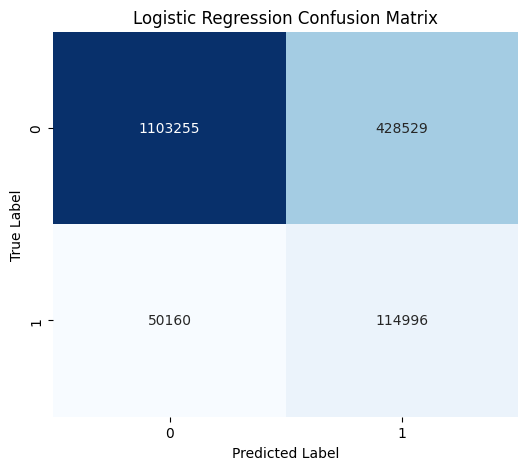


================ Random Forest PERFORMANCE ================
              precision    recall  f1-score   support

           0       0.96      0.75      0.84   1531784
           1       0.23      0.69      0.34    165156

    accuracy                           0.74   1696940
   macro avg       0.59      0.72      0.59   1696940
weighted avg       0.89      0.74      0.79   1696940

ROC AUC Score: 0.7968


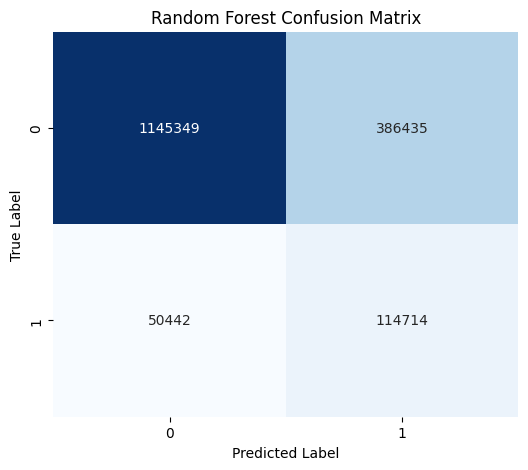

In [ ]:
#evalute the performance and comparison
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

def evaluate_performance(name, y_true, y_pred, y_prob):
    print(f"\n================ {name} PERFORMANCE ================")

    # Standard Metrics
    print(classification_report(y_true, y_pred))

    # ROC AUC
    auc = roc_auc_score(y_true, y_prob)
    print(f"ROC AUC Score: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Run Evaluation
evaluate_performance("Logistic Regression", y_val, y_pred_lr, y_prob_lr)
evaluate_performance("Random Forest", y_val, y_pred_rf, y_prob_rf)

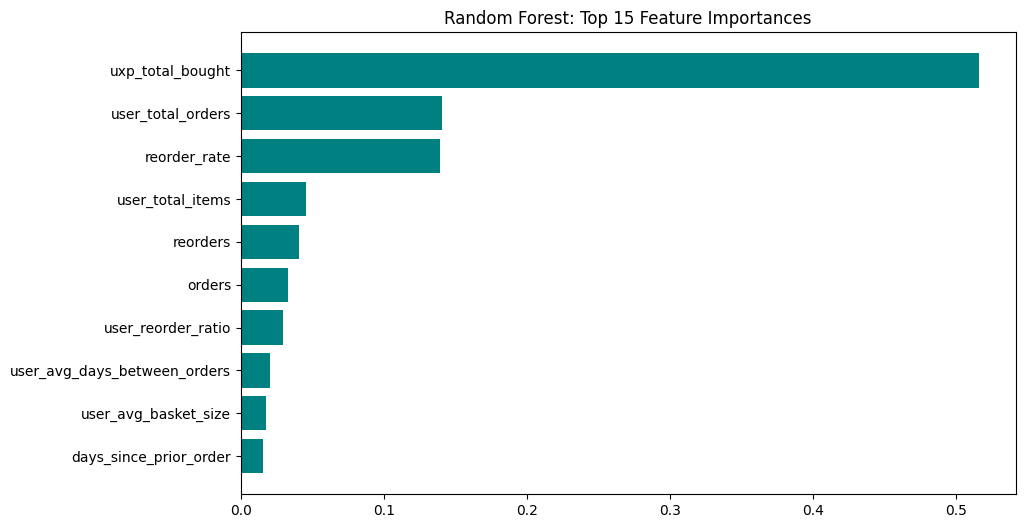

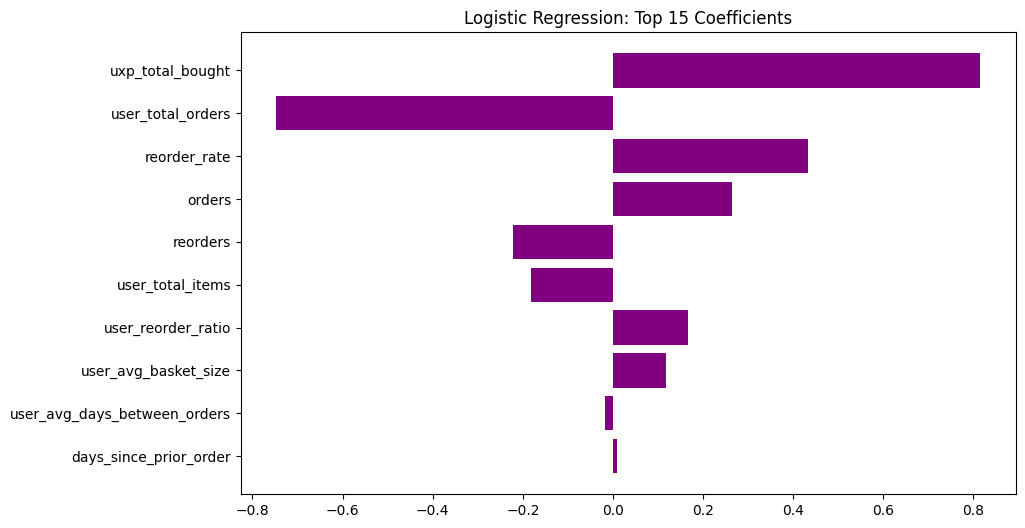

In [ ]:
#visualize what features drove the predictions, fulfilling the interpretability requirement


# Random Forest Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:15] # Top 15

plt.figure(figsize=(10, 6))
plt.title("Random Forest: Top 15 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center', color='teal')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.gca().invert_yaxis()
plt.show()

# ogistic Regression Coefficients
# Positive = Likely to reorder, Negative = Unlikely
coefs = log_reg.coef_[0]
indices_lr = np.argsort(np.abs(coefs))[::-1][:15] # Top 15 by magnitude

plt.figure(figsize=(10, 6))
plt.title("Logistic Regression: Top 15 Coefficients")
plt.barh(range(len(indices_lr)), coefs[indices_lr], align='center', color='purple')
plt.yticks(range(len(indices_lr)), [X_train.columns[i] for i in indices_lr])
plt.gca().invert_yaxis()
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

print("Preparing Data for Regression Task...")


if 'data' not in locals():
    print(" Data variable not found. Reloading from Drive...")
    # Make sure this path matches where i have  saved it
    data = pd.read_pickle('/content/drive/My Drive/instacart_train_data.pkl')
    print("Data reloaded successfully.")

# Define the Regression Target
# We want to predict: "How many days until this user orders again?"
reg_target_col = 'days_since_prior_order'

# Handle Missing Values in Target
# If a user is ordering for the first time, days_since_prior_order might be NaN.
data_reg = data.dropna(subset=[reg_target_col]).copy()

# Define Features (X) and Target (y)
#  Drop the target column from X so the model doesn't cheat
features_to_drop_reg = ['user_id', 'product_id', 'eval_set', 'order_id', 'reordered', reg_target_col]

X_reg = data_reg.drop(columns=features_to_drop_reg, errors='ignore')
y_reg = data_reg[reg_target_col]
groups_reg = data_reg['user_id']

# Split Data  80% Train, 20% Validation
gss_reg = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in gss_reg.split(X_reg, y_reg, groups_reg):
    X_reg_train, X_reg_val = X_reg.iloc[train_idx], X_reg.iloc[val_idx]
    y_reg_train, y_reg_val = y_reg.iloc[train_idx], y_reg.iloc[val_idx]

print(f"Regression Data Ready.")
print(f"Train Shape: {X_reg_train.shape}")
print(f"Target: {reg_target_col}")

Preparing Data for Regression Task...
Regression Data Ready.
Train Shape: (6777721, 9)
Target: days_since_prior_order


In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("Training XGBoost Regressor (Handles the full dataset)")

# Initialize XGBoost Regressor
xgb_reg = XGBRegressor(
    n_estimators=100,       # 100 Trees
    max_depth=6,            # Standard depth
    learning_rate=0.1,      # Standard learning rate
    objective='reg:squarederror', # Regression objective
    tree_method='hist',     # Fast training method
    n_jobs=-1,
    random_state=42
)

# Train
xgb_reg.fit(X_reg_train, y_reg_train)

# Predict
y_pred_reg = xgb_reg.predict(X_reg_val)

print("XGBoost Regression Training Complete.")

Training XGBoost Regressor (Handles the full dataset)
XGBoost Regression Training Complete.


XGBoost Results
RSME: 8.69
R-Squared: 0.3002
(RMSE is the average error in 'days'. R2 explains variance.)


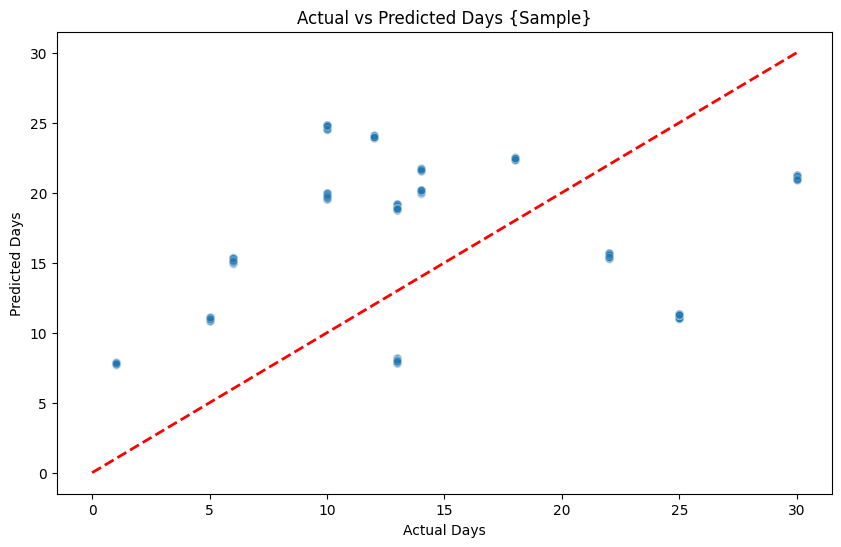

<Figure size 1000x600 with 0 Axes>

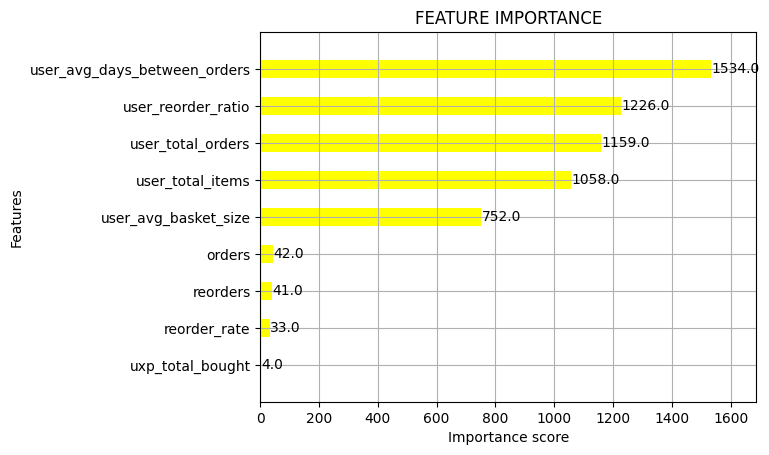

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


print("XGBoost Results")

mse= mean_squared_error(y_reg_val, y_pred_reg)
rsme=np.sqrt(mse)
r2=r2_score(y_reg_val, y_pred_reg)

print(f"RSME: {rsme:.2f}")
print(f"R-Squared: {r2:.4f}")
print("(RMSE is the average error in 'days'. R2 explains variance.)")

#visual for the actual vs predicted
#plot small sample to avoid overplotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_reg_val[:1000], y=y_pred_reg[:1000], alpha=0.2)
plt.plot([0, 30], [0, 30], 'r--', lw=2) # Perfect prediction line
plt.xlabel("Actual Days")
plt.ylabel("Predicted Days")
plt.title("Actual vs Predicted Days {Sample}")
plt.show()


#feature importance
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_reg,max_num_features=10, importance_type='weight', height=0.5, color='yellow')
plt.title("FEATURE IMPORTANCE")
plt.show()


